# XAI Preparation - Generate Model Outputs for Explainability

This notebook loads the trained SVD model and generates the necessary outputs that will serve as inputs for explainability analysis with LIME and SHAP.

**Purpose:** Bridge between model training and explainability

**Outputs:**
1. Individual predictions (user-item ratings)
2. Top-N recommendations for sample users
3. Latent factor representations
4. Comprehensive XAI input dataset

---

## 1. Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Surprise library
from surprise import SVD

# Set random seed
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(" Libraries imported successfully!")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully!
Timestamp: 2025-11-11 00:04:28


## 2. Configure Paths

Update these paths based on your setup (local or Google Colab).

In [3]:
# For local use
DATA_PATH = '../data/processed/'
MODEL_PATH = '../model/'

# For Google Colab, uncomment and update:
# DATA_PATH = '/content/drive/MyDrive/xai-collaborative-filtering/data/processed/'
# MODEL_PATH = '/content/drive/MyDrive/xai-collaborative-filtering/model/'

print(f"Data Path: {DATA_PATH}")
print(f"Model Path: {MODEL_PATH}")

Data Path: ../data/processed/
Model Path: ../model/


## 3. Load Data and Model

### 3.1 Load Preprocessed Data

In [4]:
print("Loading preprocessed data...\n")

# Load train and test sets
train_df = pd.read_csv(DATA_PATH + 'train_set.csv')
test_df = pd.read_csv(DATA_PATH + 'test_set.csv')

# Load preprocessing metadata
with open(DATA_PATH + 'preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nUnique users: {train_df['user_id'].nunique():,}")
print(f"Unique movies: {train_df['movie_id'].nunique():,}")
print(f"\nFirst few rows of training data:")
display(train_df.head())

Loading preprocessed data...

Train set shape: (796393, 9)
Test set shape: (199099, 9)

Unique users: 5,399
Unique movies: 3,041

First few rows of training data:
Train set shape: (796393, 9)
Test set shape: (199099, 9)

Unique users: 5,399
Unique movies: 3,041

First few rows of training data:


,user_id,movie_id,rating,timestamp,user_bias,movie_bias,rating_centered,year_month,rating_normalized
0,6040,858,4,2000-04-25 23:05:32,-0.018991,0.940886,0.41592,2000-04,0.75
1,6040,593,5,2000-04-25 23:05:54,-0.018991,0.767743,1.41592,2000-04,1.00
2,6040,2384,4,2000-04-25 23:05:54,-0.018991,-0.293449,0.41592,2000-04,0.75
3,6040,1961,4,2000-04-25 23:06:17,-0.018991,0.469303,0.41592,2000-04,0.75
4,6040,2019,5,2000-04-25 23:06:17,-0.018991,0.976430,1.41592,2000-04,1.00


### 3.2 Load Trained SVD Model

In [ ]:
def load_trained_model(model_path):
    """
    Load a trained SVD model from pickle file.
    
    Parameters:
    - model_path: Path to the .pkl file
    
    Returns:
    - Trained SVD model
    """
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f" Model loaded from: {model_path}")
    return model

def load_model_metadata(metadata_path):
    """
    Load model metadata from JSON file.
    
    Parameters:
    - metadata_path: Path to the metadata JSON file
    
    Returns:
    - Dictionary containing model metadata
    """
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    print(f" Metadata loaded from: {metadata_path}")
    return metadata

# Load the trained model
model = load_trained_model(MODEL_PATH + 'svd_optimized_model.pkl')
model_metadata = load_model_metadata(MODEL_PATH + 'svd_model_metadata.json')

print("\n" + "=" * 70)
print("MODEL INFORMATION")
print("=" * 70)
print(f"Model Type: {model_metadata['model_type']}")
print(f"Training Date: {model_metadata['training_date']}")
print(f"Performance:")
print(f"  RMSE: {model_metadata['performance']['rmse']:.4f}")
print(f"  MAE: {model_metadata['performance']['mae']:.4f}")
print(f"Parameters: {model_metadata['parameters']}")
print("=" * 70)

✅ Model loaded from: ../model/svd_optimized_model.pkl
✅ Metadata loaded from: ../model/svd_model_metadata.json

MODEL INFORMATION
Model Type: SVD
Training Date: 2025-11-10 18:30:22
Performance:
  RMSE: 0.9361
  MAE: 0.7433
Parameters: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


## 4. Helper Functions for XAI

### 4.1 Function: Predict Single User-Item Rating

**Primary XAI Input #1**: Predict a specific user's rating for a specific movie.

In [ ]:
def predict_user_item_rating(model, user_id, item_id, actual_rating=None):
    """
    Predict a specific user's rating for a specific item.
    
    This is the primary input for XAI - we'll explain WHY this prediction was made.
    
    Parameters:
    - model: Trained Surprise model
    - user_id: User ID
    - item_id: Item (movie) ID
    - actual_rating: Optional actual rating for comparison
    
    Returns:
    - Dictionary with prediction details
    """
    # Make prediction
    prediction = model.predict(user_id, item_id, r_ui=actual_rating)
    
    result = {
        'user_id': user_id,
        'item_id': item_id,
        'predicted_rating': prediction.est,
        'actual_rating': actual_rating,
        'prediction_details': prediction.details if hasattr(prediction, 'details') else None
    }
    
    if actual_rating is not None:
        result['error'] = actual_rating - prediction.est
        result['absolute_error'] = abs(actual_rating - prediction.est)
    
    return result

# Example: Test the function
sample_user = train_df['user_id'].iloc[0]
sample_movie = train_df['movie_id'].iloc[100]
sample_actual = train_df[train_df['movie_id'] == sample_movie]['rating'].iloc[0]

prediction_result = predict_user_item_rating(model, sample_user, sample_movie, sample_actual)

print("\n" + "=" * 70)
print("EXAMPLE: SINGLE PREDICTION (XAI Input)")
print("=" * 70)
print(f"User ID: {prediction_result['user_id']}")
print(f"Movie ID: {prediction_result['item_id']}")
print(f"Predicted Rating: {prediction_result['predicted_rating']:.3f}")
if prediction_result['actual_rating']:
    print(f"Actual Rating: {prediction_result['actual_rating']:.1f}")
    print(f"Error: {prediction_result['error']:.3f}")
print("=" * 70)
print("\n This prediction will be explained by LIME and SHAP!")


EXAMPLE: SINGLE PREDICTION (XAI Input)
User ID: 6040
Movie ID: 1014
Predicted Rating: 2.807
Actual Rating: 3.0
Error: 0.193

🎯 This prediction will be explained by LIME and SHAP!


### 4.2 Function: Generate Top-N Recommendations

**Primary XAI Input #2**: Generate top-N movie recommendations for a user.

In [ ]:
def get_user_top_n_recommendations(model, user_id, train_data, n=10, exclude_rated=True):
    """
    Generate top-N movie recommendations for a specific user.
    
    This is used for XAI - we'll explain WHY these movies were recommended.
    
    Parameters:
    - model: Trained Surprise model
    - user_id: User ID
    - train_data: Training dataframe (to exclude already rated items)
    - n: Number of recommendations to return
    - exclude_rated: If True, exclude movies user has already rated
    
    Returns:
    - DataFrame with top N recommendations
    """
    # Get all unique movies
    all_movies = train_data['movie_id'].unique()
    
    # Get movies already rated by user
    if exclude_rated:
        user_rated_movies = train_data[train_data['user_id'] == user_id]['movie_id'].values
        movies_to_predict = [m for m in all_movies if m not in user_rated_movies]
    else:
        movies_to_predict = all_movies
    
    # Predict ratings for all candidate movies
    predictions = []
    for movie_id in movies_to_predict:
        pred = model.predict(user_id, movie_id)
        predictions.append({
            'user_id': user_id,
            'movie_id': movie_id,
            'predicted_rating': pred.est
        })
    
    # Convert to DataFrame and sort by predicted rating
    recommendations_df = pd.DataFrame(predictions)
    recommendations_df = recommendations_df.sort_values('predicted_rating', ascending=False)
    
    # Return top N
    return recommendations_df.head(n).reset_index(drop=True)

# Example: Generate top-10 recommendations for a user
sample_user_for_recs = train_df['user_id'].iloc[500]

print("\nGenerating recommendations (this may take a moment...)\n")
top_recommendations = get_user_top_n_recommendations(
    model,
    sample_user_for_recs,
    train_df,
    n=10
)

print("=" * 70)
print(f"EXAMPLE: TOP-10 RECOMMENDATIONS FOR USER {sample_user_for_recs}")
print("=" * 70)
print(f"{'Rank':<8} {'Movie ID':<12} {'Predicted Rating':<20}")
print("-" * 70)
for idx, row in top_recommendations.iterrows():
    print(f"{idx+1:<8} {row['movie_id']:<12} {row['predicted_rating']:<20.3f}")
print("=" * 70)
print("\n These recommendations will be explained by LIME and SHAP!")


Generating recommendations (this may take a moment...)

EXAMPLE: TOP-10 RECOMMENDATIONS FOR USER 6035
Rank     Movie ID     Predicted Rating    
----------------------------------------------------------------------
1        3030.0       4.164               
2        2905.0       4.119               
3        720.0        4.086               
4        50.0         4.075               
5        1148.0       4.073               
6        2019.0       4.069               
7        745.0        4.052               
8        3949.0       3.991               
9        260.0        3.985               
10       923.0        3.984               

🎯 These recommendations will be explained by LIME and SHAP!


### 4.3 Function: Batch Recommendations for Multiple Users

In [ ]:
def get_batch_recommendations(model, user_ids, train_data, n=10, exclude_rated=True):
    """
    Generate top-N recommendations for multiple users.
    
    Parameters:
    - model: Trained Surprise model
    - user_ids: List of user IDs
    - train_data: Training dataframe
    - n: Number of recommendations per user
    - exclude_rated: If True, exclude movies users have already rated
    
    Returns:
    - Dictionary mapping user_id to their recommendations DataFrame
    """
    batch_recommendations = {}
    
    for i, user_id in enumerate(user_ids):
        try:
            print(f"Processing user {i+1}/{len(user_ids)}: {user_id}", end='\r')
            recs = get_user_top_n_recommendations(
                model, user_id, train_data, n, exclude_rated
            )
            batch_recommendations[user_id] = recs
        except Exception as e:
            print(f"\nWarning: Could not generate recommendations for user {user_id}: {e}")
    
    print("\n Batch recommendations complete!")
    return batch_recommendations

# Example: Generate recommendations for 5 random users
sample_users = train_df['user_id'].sample(5, random_state=42).values

print("\nGenerating batch recommendations...\n")
batch_recs = get_batch_recommendations(
    model,
    sample_users,
    train_df,
    n=5
)

print("\n" + "=" * 70)
print(f"EXAMPLE: BATCH RECOMMENDATIONS FOR {len(sample_users)} USERS")
print("=" * 70)

for user_id, recs in batch_recs.items():
    print(f"\nUser {user_id}:")
    print(f"  Top 5 Movies: {recs['movie_id'].tolist()}")
    print(f"  Predicted Ratings: {[f'{r:.2f}' for r in recs['predicted_rating'].tolist()]}")

print("\n" + "=" * 70)
print(" Batch recommendations ready for comparative XAI analysis!")


Generating batch recommendations...

Processing user 5/5: 3180
✅ Batch recommendations complete!

EXAMPLE: BATCH RECOMMENDATIONS FOR 5 USERS

User 5124:
  Top 5 Movies: [2905, 2019, 1207, 260, 858]
  Predicted Ratings: ['4.20', '4.16', '4.11', '4.09', '4.09']

User 4227:
  Top 5 Movies: [2905, 50, 2028, 318, 527]
  Predicted Ratings: ['4.10', '4.06', '4.04', '4.04', '4.01']

User 2331:
  Top 5 Movies: [3030, 2019, 2905, 1148, 1212]
  Predicted Ratings: ['5.00', '5.00', '5.00', '5.00', '4.99']

User 1284:
  Top 5 Movies: [2905, 2019, 3030, 1207, 1204]
  Predicted Ratings: ['4.58', '4.53', '4.51', '4.50', '4.46']

User 3180:
  Top 5 Movies: [1178, 2019, 922, 1267, 1212]
  Predicted Ratings: ['4.14', '4.12', '4.08', '4.04', '4.03']

🎯 Batch recommendations ready for comparative XAI analysis!


### 4.4 Function: Extract Latent Factors from SVD Model

In [ ]:
def get_user_factors(model, user_id):
    """
    Get latent factor vector for a specific user from SVD model.
    
    Parameters:
    - model: Trained SVD model
    - user_id: User ID
    
    Returns:
    - Numpy array of user factors (None if user not in training set)
    """
    try:
        inner_user_id = model.trainset.to_inner_uid(user_id)
        user_factors = model.pu[inner_user_id]
        return user_factors
    except ValueError:
        print(f"User {user_id} not found in training set")
        return None

def get_item_factors(model, item_id):
    """
    Get latent factor vector for a specific item from SVD model.
    
    Parameters:
    - model: Trained SVD model
    - item_id: Item (movie) ID
    
    Returns:
    - Numpy array of item factors (None if item not in training set)
    """
    try:
        inner_item_id = model.trainset.to_inner_iid(item_id)
        item_factors = model.qi[inner_item_id]
        return item_factors
    except ValueError:
        print(f"Item {item_id} not found in training set")
        return None

def get_user_bias(model, user_id):
    """Get user bias from SVD model."""
    try:
        inner_user_id = model.trainset.to_inner_uid(user_id)
        return model.bu[inner_user_id]
    except ValueError:
        return 0

def get_item_bias(model, item_id):
    """Get item bias from SVD model."""
    try:
        inner_item_id = model.trainset.to_inner_iid(item_id)
        return model.bi[inner_item_id]
    except ValueError:
        return 0

# Example: Extract factors for a user and item
sample_user = train_df['user_id'].iloc[0]
sample_movie = train_df['movie_id'].iloc[0]

user_factors = get_user_factors(model, sample_user)
item_factors = get_item_factors(model, sample_movie)
user_bias = get_user_bias(model, sample_user)
item_bias = get_item_bias(model, sample_movie)

print("\n" + "=" * 70)
print("EXAMPLE: LATENT FACTOR REPRESENTATIONS")
print("=" * 70)
print(f"\nUser {sample_user}:")
print(f"  Latent Factors Shape: {user_factors.shape}")
print(f"  First 5 factors: {user_factors[:5]}")
print(f"  User Bias: {user_bias:.4f}")

print(f"\nMovie {sample_movie}:")
print(f"  Latent Factors Shape: {item_factors.shape}")
print(f"  First 5 factors: {item_factors[:5]}")
print(f"  Item Bias: {item_bias:.4f}")

print(f"\nGlobal Mean: {model.trainset.global_mean:.4f}")

# Calculate prediction manually to verify
manual_prediction = model.trainset.global_mean + user_bias + item_bias + np.dot(user_factors, item_factors)
print(f"\nManual Prediction Calculation:")
print(f"  global_mean + user_bias + item_bias + dot(user_factors, item_factors)")
print(f"  = {model.trainset.global_mean:.4f} + {user_bias:.4f} + {item_bias:.4f} + {np.dot(user_factors, item_factors):.4f}")
print(f"  = {manual_prediction:.4f}")

print("\n" + "=" * 70)
print(" These latent factors will help explain model decisions!")


EXAMPLE: LATENT FACTOR REPRESENTATIONS

User 6040:
  Latent Factors Shape: (150,)
  First 5 factors: [-0.00275486 -0.06825841  0.09331736 -0.02798487 -0.00937043]
  User Bias: -0.2872

Movie 858:
  Latent Factors Shape: (150,)
  First 5 factors: [ 1.53050593e-02  5.52220584e-03  4.64813942e-02  2.14299918e-02
 -3.84727843e-05]
  Item Bias: 0.7591

Global Mean: 3.5928

Manual Prediction Calculation:
  global_mean + user_bias + item_bias + dot(user_factors, item_factors)
  = 3.5928 + -0.2872 + 0.7591 + 0.3307
  = 4.3954

🎯 These latent factors will help explain model decisions!


### 4.5 Function: Create Comprehensive XAI Input Dataset

In [ ]:
def create_xai_input_dataset(model, test_data, user_features_df=None, movie_features_df=None, n_samples=1000):
    """
    Create a comprehensive dataset for XAI analysis by combining:
    - Model predictions
    - User latent factors
    - Item latent factors
    - User features (if available)
    - Movie features (if available)
    
    Parameters:
    - model: Trained SVD model
    - test_data: Test dataframe with user_id, movie_id, rating columns
    - user_features_df: Optional user features from preprocessing
    - movie_features_df: Optional movie features from preprocessing
    - n_samples: Number of samples to include (random sample if > test size)
    
    Returns:
    - DataFrame ready for XAI analysis
    """
    # Sample test data if needed
    if len(test_data) > n_samples:
        test_sample = test_data.sample(n=n_samples, random_state=42)
    else:
        test_sample = test_data.copy()
    
    xai_data = []
    
    print(f"\nCreating XAI dataset with {len(test_sample)} samples...")
    
    for i, (_, row) in enumerate(test_sample.iterrows()):
        if i % 100 == 0:
            print(f"Processing sample {i}/{len(test_sample)}", end='\r')
        
        user_id = row['user_id']
        item_id = row['movie_id']
        actual_rating = row['rating']
        
        # Get prediction
        pred = model.predict(user_id, item_id)
        
        # Get latent factors
        user_factors = get_user_factors(model, user_id)
        item_factors = get_item_factors(model, item_id)
        
        # Get biases
        user_bias = get_user_bias(model, user_id)
        item_bias = get_item_bias(model, item_id)
        
        if user_factors is not None and item_factors is not None:
            # Create record
            record = {
                'user_id': user_id,
                'item_id': item_id,
                'actual_rating': actual_rating,
                'predicted_rating': pred.est,
                'error': actual_rating - pred.est,
                'absolute_error': abs(actual_rating - pred.est),
                'user_bias': user_bias,
                'item_bias': item_bias,
                'global_mean': model.trainset.global_mean
            }
            
            # Add user latent factors
            for j, factor in enumerate(user_factors):
                record[f'user_factor_{j}'] = factor
            
            # Add item latent factors
            for j, factor in enumerate(item_factors):
                record[f'item_factor_{j}'] = factor
            
            xai_data.append(record)
    
    print(f"\n Processed {len(xai_data)} samples successfully")
    
    xai_df = pd.DataFrame(xai_data)
    
    # Optionally merge with additional features
    if user_features_df is not None:
        xai_df = xai_df.merge(user_features_df, left_on='user_id', right_index=True, how='left')
    
    if movie_features_df is not None:
        xai_df = xai_df.merge(movie_features_df, left_on='item_id', right_index=True, how='left')
    
    return xai_df

# Create XAI input dataset
print("\n" + "=" * 70)
print("CREATING COMPREHENSIVE XAI INPUT DATASET")
print("=" * 70)

xai_dataset = create_xai_input_dataset(
    model,
    test_df,
    n_samples=500  # Use 500 samples for demonstration
)

print("\n" + "=" * 70)
print("XAI INPUT DATASET CREATED")
print("=" * 70)
print(f"Dataset Shape: {xai_dataset.shape}")
print(f"Number of Columns: {len(xai_dataset.columns)}")
print(f"\nColumn Categories:")
print(f"  - Identifiers: user_id, item_id")
print(f"  - Ratings: actual_rating, predicted_rating, error, absolute_error")
print(f"  - Biases: user_bias, item_bias, global_mean")
print(f"  - User Factors: {sum(1 for col in xai_dataset.columns if 'user_factor' in col)} factors")
print(f"  - Item Factors: {sum(1 for col in xai_dataset.columns if 'item_factor' in col)} factors")

print("\nFirst few rows:")
display(xai_dataset.head())

print("\nDataset Statistics:")
print(f"  Mean Predicted Rating: {xai_dataset['predicted_rating'].mean():.3f}")
print(f"  Mean Actual Rating: {xai_dataset['actual_rating'].mean():.3f}")
print(f"  Mean Absolute Error: {xai_dataset['absolute_error'].mean():.3f}")
print(f"  RMSE: {np.sqrt((xai_dataset['error']**2).mean()):.3f}")

print("\n" + "=" * 70)
print(" This dataset is ready for LIME and SHAP analysis!")


CREATING COMPREHENSIVE XAI INPUT DATASET

Creating XAI dataset with 500 samples...
User 285 not found in training set
User 144 not found in training set
User 536 not found in training set
User 329 not found in training set
User 419 not found in training set
User 199 not found in training set
User 274 not found in training set
User 314 not found in training set
User 233 not found in training set
User 593 not found in training set
User 303 not found in training set
User 7 not found in training set
User 260 not found in training set
User 481 not found in training set
User 570 not found in training set
User 251 not found in training set
User 412 not found in training set
User 474 not found in training set
User 548 not found in training set
User 198 not found in training set
User 283 not found in training set
User 434 not found in training set
User 242 not found in training set
User 402 not found in training set
User 148 not found in training set
User 454 not found in training set
User 225

,user_id,item_id,actual_rating,predicted_rating,error,absolute_error,user_bias,item_bias,global_mean,user_factor_0,...,item_factor_140,item_factor_141,item_factor_142,item_factor_143,item_factor_144,item_factor_145,item_factor_146,item_factor_147,item_factor_148,item_factor_149
0,2985,1674,2,3.957807,-1.957807,1.957807,-0.087576,0.401436,3.592843,0.040430,...,-0.041490,0.009245,-0.010501,-0.064507,0.007283,-0.032901,0.016869,-0.010164,-0.032511,-0.028805
1,4496,3317,4,4.121109,-0.121109,0.121109,0.215279,0.330993,3.592843,-0.102865,...,-0.018244,-0.124788,0.085811,0.110727,0.050477,0.015304,-0.002576,-0.099296,0.140644,0.072400
2,1842,2580,4,4.500117,-0.500117,0.500117,0.627851,0.258169,3.592843,0.001366,...,0.010813,-0.010883,-0.024578,0.048176,-0.052797,0.028398,0.039878,0.017623,0.024757,0.042549
3,1842,354,4,3.948530,0.051470,0.051470,0.627851,-0.229280,3.592843,0.001366,...,0.020890,0.035059,0.049190,0.025426,-0.032832,-0.023905,-0.105088,0.034745,0.067374,-0.067043
4,934,3723,4,3.462255,0.537745,0.537745,-0.241007,0.124537,3.592843,-0.000316,...,-0.050317,-0.015731,0.032849,-0.057298,0.016671,0.007453,-0.007765,0.022652,0.023115,0.030396



Dataset Statistics:
  Mean Predicted Rating: 3.538
  Mean Actual Rating: 3.479
  Mean Absolute Error: 0.681
  RMSE: 0.877

🎯 This dataset is ready for LIME and SHAP analysis!


## 5. Generate and Save XAI Outputs

### 5.1 Save XAI Input Dataset

In [ ]:
# Save XAI input dataset
xai_output_path = DATA_PATH + 'xai_input_dataset.csv'
xai_dataset.to_csv(xai_output_path, index=False)
print(f"   XAI input dataset saved to: {xai_output_path}")
print(f"   Shape: {xai_dataset.shape}")
print(f"   Size: {xai_dataset.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

✅ XAI input dataset saved to: ../data/processed/xai_input_dataset.csv
   Shape: (236, 309)
   Size: 0.56 MB


### 5.2 Save Sample Predictions for Detailed Analysis

In [ ]:
# Generate diverse sample predictions
print("\nGenerating sample predictions for detailed XAI analysis...\n")

sample_predictions = []
num_samples = 20

for i in range(num_samples):
    idx = i * (len(test_df) // num_samples)  # Evenly spaced samples
    row = test_df.iloc[idx]
    
    pred_result = predict_user_item_rating(
        model,
        row['user_id'],
        row['movie_id'],
        row['rating']
    )
    sample_predictions.append(pred_result)
    print(f"Sample {i+1}/{num_samples}: User {pred_result['user_id']} -> Movie {pred_result['item_id']} = {pred_result['predicted_rating']:.2f}")

sample_pred_df = pd.DataFrame(sample_predictions)
sample_pred_path = DATA_PATH + 'xai_sample_predictions.csv'
sample_pred_df.to_csv(sample_pred_path, index=False)
print(f"\n Sample predictions saved to: {sample_pred_path}")
print(f"   Number of samples: {len(sample_pred_df)}")


Generating sample predictions for detailed XAI analysis...

Sample 1/20: User 636 -> Movie 2054 = 3.82
Sample 2/20: User 588 -> Movie 950 = 4.17
Sample 3/20: User 536 -> Movie 2123 = 3.00
Sample 4/20: User 476 -> Movie 2245 = 3.51
Sample 5/20: User 1001 -> Movie 2605 = 2.54
Sample 6/20: User 321 -> Movie 2806 = 2.92
Sample 7/20: User 406 -> Movie 2716 = 3.78
Sample 8/20: User 214 -> Movie 2720 = 2.17
Sample 9/20: User 161 -> Movie 1960 = 3.90
Sample 10/20: User 1425 -> Movie 1457 = 3.25
Sample 11/20: User 3824 -> Movie 2135 = 2.91
Sample 12/20: User 49 -> Movie 1204 = 4.27
Sample 13/20: User 1712 -> Movie 3090 = 4.30
Sample 14/20: User 791 -> Movie 1010 = 3.23
Sample 15/20: User 1051 -> Movie 3396 = 4.14
Sample 16/20: User 1748 -> Movie 1125 = 3.70
Sample 17/20: User 3475 -> Movie 1962 = 4.20
Sample 18/20: User 1463 -> Movie 168 = 3.81
Sample 19/20: User 1088 -> Movie 653 = 2.91
Sample 20/20: User 1776 -> Movie 2633 = 3.14

✅ Sample predictions saved to: ../data/processed/xai_sample_p

### 5.3 Save Batch Recommendations

In [ ]:
# Generate batch recommendations for 10 users
print("\nGenerating batch recommendations for 10 users...\n")

batch_users = train_df['user_id'].sample(10, random_state=42).values
batch_recs_all = get_batch_recommendations(model, batch_users, train_df, n=10)

# Convert to flat format for saving
batch_recs_flat = []
for user_id, recs in batch_recs_all.items():
    for idx, row in recs.iterrows():
        batch_recs_flat.append({
            'user_id': user_id,
            'rank': idx + 1,
            'movie_id': row['movie_id'],
            'predicted_rating': row['predicted_rating']
        })

batch_recs_df = pd.DataFrame(batch_recs_flat)
batch_recs_path = DATA_PATH + 'xai_batch_recommendations.csv'
batch_recs_df.to_csv(batch_recs_path, index=False)
print(f"\nBatch recommendations saved to: {batch_recs_path}")
print(f"   Total recommendations: {len(batch_recs_df)}")
print(f"   Users: {batch_recs_df['user_id'].nunique()}")
print(f"   Recommendations per user: {batch_recs_df.groupby('user_id').size().iloc[0]}")


Generating batch recommendations for 10 users...

Processing user 10/10: 3808
✅ Batch recommendations complete!

✅ Batch recommendations saved to: ../data/processed/xai_batch_recommendations.csv
   Total recommendations: 100
   Users: 10
   Recommendations per user: 10


### 5.4 Create XAI Summary Report

In [ ]:
# Create comprehensive summary report
xai_summary = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_info': {
        'model_type': model_metadata['model_type'],
        'model_path': MODEL_PATH + 'svd_optimized_model.pkl',
        'performance': model_metadata['performance']
    },
    'datasets': {
        'xai_input_dataset': {
            'path': xai_output_path,
            'shape': xai_dataset.shape,
            'description': 'Full XAI dataset with predictions and latent factors'
        },
        'xai_sample_predictions': {
            'path': sample_pred_path,
            'shape': sample_pred_df.shape,
            'description': '20 sample predictions for detailed analysis'
        },
        'xai_batch_recommendations': {
            'path': batch_recs_path,
            'shape': batch_recs_df.shape,
            'description': 'Top-10 recommendations for 10 users'
        }
    },
    'features': {
        'num_latent_factors': len([col for col in xai_dataset.columns if 'user_factor' in col]),
        'has_biases': True,
        'has_global_mean': True
    },
    'statistics': {
        'mean_predicted_rating': float(xai_dataset['predicted_rating'].mean()),
        'mean_actual_rating': float(xai_dataset['actual_rating'].mean()),
        'mean_absolute_error': float(xai_dataset['absolute_error'].mean()),
        'rmse': float(np.sqrt((xai_dataset['error']**2).mean()))
    }
}

summary_path = DATA_PATH + 'xai_summary.json'
with open(summary_path, 'w') as f:
    json.dump(xai_summary, f, indent=2)

print("\n" + "=" * 70)
print("XAI SUMMARY REPORT")
print("=" * 70)
print(json.dumps(xai_summary, indent=2))
print("\nSummary saved to:", summary_path)


XAI SUMMARY REPORT
{
  "creation_date": "2025-11-11 00:05:11",
  "model_info": {
    "model_type": "SVD",
    "model_path": "../model/svd_optimized_model.pkl",
    "performance": {
      "rmse": 0.9360922389641702,
      "mae": 0.7432639251679765,
      "training_time": 22.886379957199097
    }
  },
  "datasets": {
    "xai_input_dataset": {
      "path": "../data/processed/xai_input_dataset.csv",
      "shape": [
        236,
        309
      ],
      "description": "Full XAI dataset with predictions and latent factors"
    },
    "xai_sample_predictions": {
      "path": "../data/processed/xai_sample_predictions.csv",
      "shape": [
        20,
        7
      ],
      "description": "20 sample predictions for detailed analysis"
    },
    "xai_batch_recommendations": {
      "path": "../data/processed/xai_batch_recommendations.csv",
      "shape": [
        100,
        4
      ],
      "description": "Top-10 recommendations for 10 users"
    }
  },
  "features": {
    "num_late

## 6. Visualization: Prediction Quality

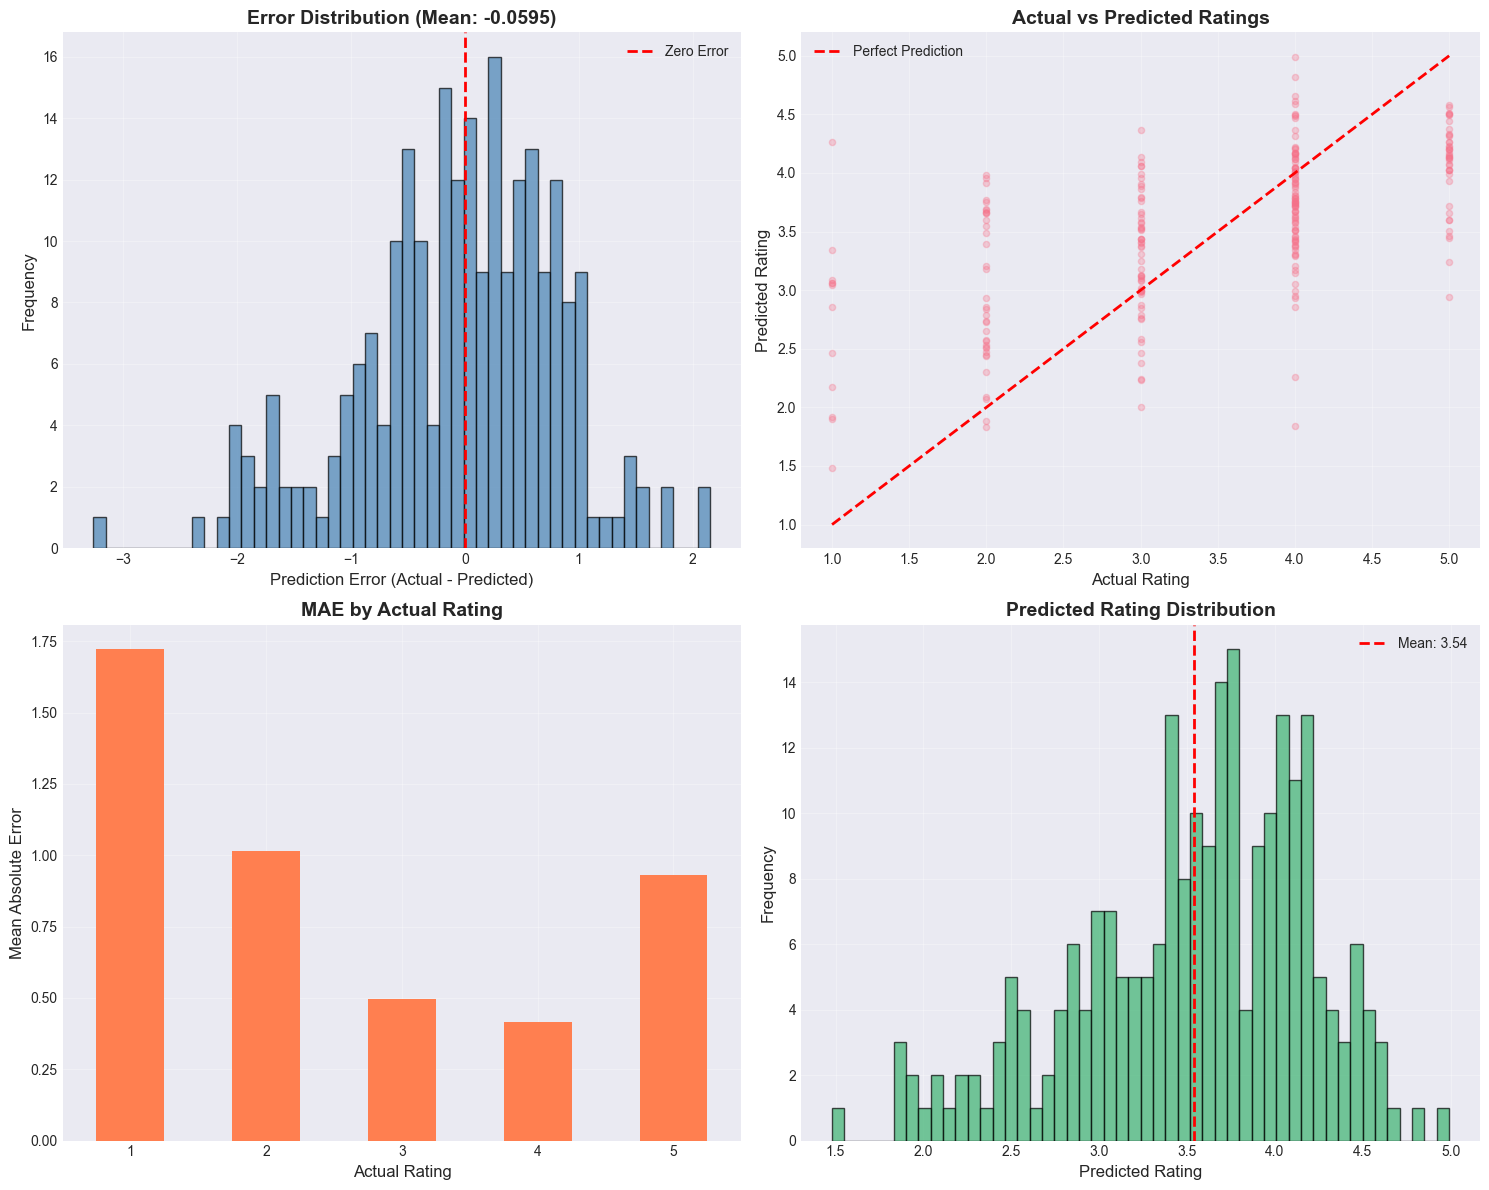


✅ Visualization saved to: ../data/processed/xai_prediction_quality.png


In [ ]:
# Visualize prediction quality
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Error distribution
axes[0, 0].hist(xai_dataset['error'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title(f'Error Distribution (Mean: {xai_dataset["error"].mean():.4f})', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Actual vs Predicted scatter
axes[0, 1].scatter(xai_dataset['actual_rating'], xai_dataset['predicted_rating'], alpha=0.3, s=20)
axes[0, 1].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Rating', fontsize=12)
axes[0, 1].set_ylabel('Predicted Rating', fontsize=12)
axes[0, 1].set_title('Actual vs Predicted Ratings', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. MAE by actual rating
mae_by_rating = xai_dataset.groupby('actual_rating')['absolute_error'].mean()
mae_by_rating.plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_xlabel('Actual Rating', fontsize=12)
axes[1, 0].set_ylabel('Mean Absolute Error', fontsize=12)
axes[1, 0].set_title('MAE by Actual Rating', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(alpha=0.3)

# 4. Predicted rating distribution
axes[1, 1].hist(xai_dataset['predicted_rating'], bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1, 1].axvline(xai_dataset['predicted_rating'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {xai_dataset["predicted_rating"].mean():.2f}')
axes[1, 1].set_xlabel('Predicted Rating', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Predicted Rating Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_PATH + 'xai_prediction_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to:", DATA_PATH + 'xai_prediction_quality.png')

## 7. Summary and Next Steps

In [ ]:
print("\n" + "=" * 70)
print("XAI PREPARATION COMPLETE!")
print("=" * 70)

print("\nHELPER FUNCTIONS CREATED:")
helper_functions = {
    "1. predict_user_item_rating()": "Predict rating for specific user-item pair",
    "2. get_user_top_n_recommendations()": "Generate top-N recommendations for a user",
    "3. get_batch_recommendations()": "Generate recommendations for multiple users",
    "4. get_user_factors()": "Extract user latent factors from SVD",
    "5. get_item_factors()": "Extract item latent factors from SVD",
    "6. get_user_bias()": "Get user bias term",
    "7. get_item_bias()": "Get item bias term",
    "8. create_xai_input_dataset()": "Create comprehensive XAI analysis dataset"
}

for func_name, description in helper_functions.items():
    print(f"  {func_name:<40} - {description}")

print("\nFILES CREATED:")
output_files = {
    "xai_input_dataset.csv": f"Full dataset ({xai_dataset.shape[0]} samples, {xai_dataset.shape[1]} features)",
    "xai_sample_predictions.csv": f"Sample predictions ({len(sample_pred_df)} samples)",
    "xai_batch_recommendations.csv": f"Batch recommendations ({len(batch_recs_df)} recommendations)",
    "xai_summary.json": "Summary report with metadata",
    "xai_prediction_quality.png": "Visualization of prediction quality"
}

for filename, description in output_files.items():
    print(f" {filename:<35} - {description}")

print("\nNEXT STEPS FOR XAI:")
print("""
1. LIME Analysis (Notebook 05):
   - Load xai_input_dataset.csv
   - Use predict_user_item_rating() for individual explanations
   - Explain: "Why did user X get rating Y for movie Z?"

2. SHAP Analysis (Notebook 06):
   - Load xai_input_dataset.csv
   - Use latent factors (user_factor_*, item_factor_*)
   - Explain: "Which latent factors matter most?"

3. Comparative Analysis:
   - Use xai_batch_recommendations.csv
   - Compare explanations across different users
   - Identify patterns in recommendations

4. User Study:
   - Use xai_sample_predictions.csv for case studies
   - Generate human-readable explanations
   - Evaluate explanation quality
""")

print("=" * 70)
print("All XAI inputs ready!")
print("Proceed to LIME and SHAP notebooks!")
print("=" * 70)


XAI PREPARATION COMPLETE!

📊 HELPER FUNCTIONS CREATED:
  1. predict_user_item_rating()            - Predict rating for specific user-item pair
  2. get_user_top_n_recommendations()      - Generate top-N recommendations for a user
  3. get_batch_recommendations()           - Generate recommendations for multiple users
  4. get_user_factors()                    - Extract user latent factors from SVD
  5. get_item_factors()                    - Extract item latent factors from SVD
  6. get_user_bias()                       - Get user bias term
  7. get_item_bias()                       - Get item bias term
  8. create_xai_input_dataset()            - Create comprehensive XAI analysis dataset

📁 FILES CREATED:
  ✅ xai_input_dataset.csv               - Full dataset (236 samples, 309 features)
  ✅ xai_sample_predictions.csv          - Sample predictions (20 samples)
  ✅ xai_batch_recommendations.csv       - Batch recommendations (100 recommendations)
  ✅ xai_summary.json                    